In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os
print(os.listdir("data"))

['2015-building-energy-benchmarking.csv', '2016-building-energy-benchmarking.csv', 'clean-building-energy-benchmarking.csv', 'socrata_metadata_2015-building-energy-benchmarking.json', 'socrata_metadata_2016-building-energy-benchmarking.json']


In [2]:
raw = pd.read_csv("data/clean-building-energy-benchmarking.csv")
data = raw.copy()

In [3]:
data.head()

,DataYear,ENERGYSTARScore,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,SiteEnergyUseWN(kBtu),TotalGHGEmissions,YearBuilt,...,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,ENERGYSTARCertified
0,2015,65.0,1.0,12.0,88434,0,88434,7097539.0,249.43,1927,...,0,0,0,0,0,0,0,0,0,0
1,2015,51.0,1.0,11.0,88502,15064,103566,8765788.0,263.51,1996,...,0,0,0,0,0,0,0,0,0,0
2,2015,18.0,1.0,41.0,961990,0,961990,NaN,NaN,1969,...,0,0,0,0,0,0,0,0,0,0
3,2015,NaN,1.0,10.0,61320,0,61320,28363444.0,NaN,1926,...,0,0,0,0,0,0,0,0,0,0
4,2015,67.0,1.0,18.0,107430,12460,119890,15078243.0,507.70,1980,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import time

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
def test(models, X_train, X_test, y_train, y_test):
    results = []
    for i, model in enumerate(models):
        start_time = time.time()
        models[model].fit(X_train, y_train)
        y_pred = models[model].predict(X_test)
        r2_predict = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        end_time = time.time() - start_time
        results.append([r2_predict, rmse, end_time])
    return pd.DataFrame(results, columns=["R2 Score", "RMSE", "Time"], index=models.keys())

# TotalGHGEmissions

In [6]:
df = data.copy()
df.dropna(subset=['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'], inplace=True)

In [7]:
X = df.drop(["TotalGHGEmissions", "SiteEnergyUseWN(kBtu)", "ENERGYSTARScore"], axis=1)
y = df[["TotalGHGEmissions"]]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [9]:
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
models = {'OLS': LinearRegression(),
          'Lasso': Lasso(),
          'Ridge': Ridge(),
          'SVM': SVR(kernel="linear"),
          'Random Forest': RandomForestRegressor(),
         }

In [12]:
baseline_ghg = test(models, X_train, X_test, y_train, y_test)

In [13]:
baseline_ghg

,R2 Score,RMSE,Time
OLS,-0.574904,137.326195,0.050864
Lasso,0.545190,73.797472,0.036901
Ridge,0.344077,88.624313,0.009974
SVM,0.404038,84.476427,1.982698
Random Forest,0.757886,53.843855,0.253322


### Optimisation des models

In [14]:
lasso_params = {'alpha': np.logspace(-2, -1, 20)}

grid_lasso = GridSearchCV(Lasso(), param_grid=lasso_params, n_jobs=-1, verbose = 5)
grid_lasso.fit(X_train, y_train)
grid_lasso.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed:    4.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  55 out of  60 | elapsed:    4.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.7s finished


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [15]:
ridge_params = {'alpha': np.logspace(-5, 5, 20)}

grid_ridge = GridSearchCV(Ridge(), param_grid=ridge_params, n_jobs=-1, verbose = 5)
grid_ridge.fit(X_train, y_train)
grid_ridge.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  60 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  60 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished


Ridge(alpha=233.57214690901213, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [16]:
svm_params = {'kernel': ['linear'], 'C': np.logspace(0, 2, 3)}
grid_svm = GridSearchCV(SVR(), param_grid=svm_params, n_jobs=-1, verbose = 5)
grid_svm.fit(X_train, y_train)
grid_svm.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    1.4s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    2.1s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    2.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.2s finished


SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
rfr_params = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

random_rfr = RandomizedSearchCV(RandomForestRegressor(), param_distributions=rfr_params, n_iter=100, cv=3, verbose=5, n_jobs=-1)
random_rfr.fit(X_train, y_train)
random_rfr.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.2min finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=70,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [18]:
models2 = {'OLS': LinearRegression(),
           'Lasso': grid_lasso.best_estimator_,
           'Ridge': grid_ridge.best_estimator_,
           'SVM': grid_svm.best_estimator_,
           'Random Forest': random_rfr.best_estimator_}

In [19]:
optimize_ghg = test(models2, X_train, X_test, y_train, y_test)
optimize_ghg

,R2 Score,RMSE,Time
OLS,-0.574904,137.326195,0.010972
Lasso,0.472888,79.447027,0.176526
Ridge,0.351625,88.112874,0.004987
SVM,0.406502,84.301627,15.906485
Random Forest,0.788573,50.316057,5.761559


In [20]:
scores_ghg = pd.concat([baseline_ghg, optimize_ghg], keys=['Baseline', 'Optimize'])
scores_ghg.round(3)

R2 Score     RMSE    Time
Baseline OLS              -0.575  137.326   0.051
         Lasso             0.545   73.797   0.037
         Ridge             0.344   88.624   0.010
         SVM               0.404   84.476   1.983
         Random Forest     0.758   53.844   0.253
Optimize OLS              -0.575  137.326   0.011
         Lasso             0.473   79.447   0.177
         Ridge             0.352   88.113   0.005
         SVM               0.407   84.302  15.906
         Random Forest     0.789   50.316   5.762

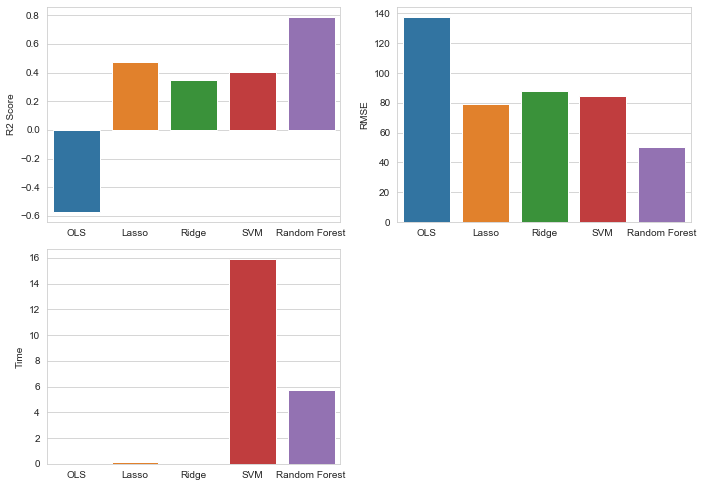

In [21]:
plt.subplots(figsize=(10, 10))

for index, column in enumerate(optimize_ghg.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=optimize_ghg.index, y=column, data=optimize_ghg)
plt.tight_layout()
plt.show()

## SiteEnergyUseWN(kBtu)

In [22]:
df = data.copy()
df.dropna(subset=['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'], inplace=True)

In [23]:
X = df.drop(["TotalGHGEmissions", "SiteEnergyUseWN(kBtu)", "ENERGYSTARScore"], axis=1)
y = df[["SiteEnergyUseWN(kBtu)"]]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [25]:
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [26]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [27]:
baseline_energy = test(models, X_train, X_test, y_train, y_test)

In [28]:
optimize_energy = test(models2, X_train, X_test, y_train, y_test)

In [29]:
scores_energy = pd.concat([baseline_energy, optimize_energy], keys=['Baseline', 'Optimize'])
scores_energy.round(3)

R2 Score         RMSE   Time
Baseline OLS               0.699  2529068.625  0.011
         Lasso             0.668  2655559.399  0.197
         Ridge             0.668  2654320.784  0.005
         SVM              -0.138  4916795.663  1.688
         Random Forest     0.843  1828653.919  0.251
Optimize OLS               0.699  2529068.625  0.011
         Lasso             0.668  2655641.240  0.231
         Ridge             0.691  2562202.795  0.006
         SVM               0.065  4456980.461  1.682
         Random Forest     0.877  1616507.434  5.717

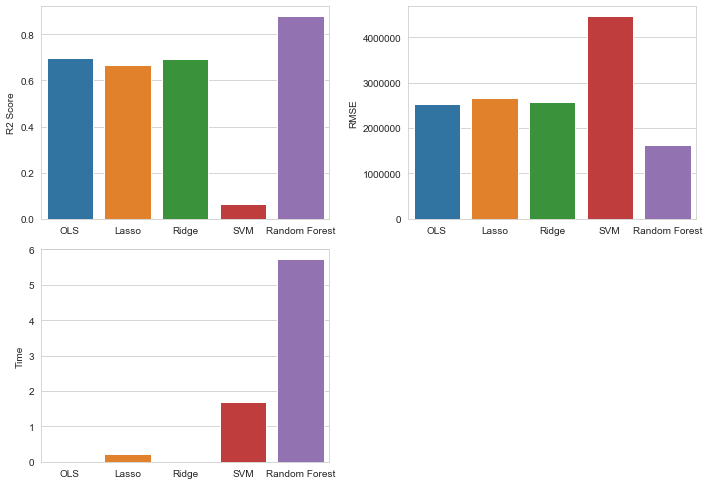

In [30]:
plt.subplots(figsize=(10, 10))

for index, column in enumerate(optimize_energy.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=optimize_ghg.index, y=column, data=optimize_energy)
plt.tight_layout()
plt.show()

## EnergyStarScore

Nous allons mesurer l'intérêt de l'EnergyStarScore pour la prédiction de TotalGHGEmissions

In [80]:
df = data.copy()
df.dropna(subset=['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'], inplace=True)

In [82]:
X = df.drop(["TotalGHGEmissions", "SiteEnergyUseWN(kBtu)"], axis=1)
y = df[["TotalGHGEmissions"]]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [84]:
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [85]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [86]:
baseline_ghg_ess = test(models, X_train, X_test, y_train, y_test)

In [87]:
optimize_ghg_ess = test(models2, X_train, X_test, y_train, y_test)

In [88]:
scores_ghg_ess = pd.concat([baseline_ghg_ess, optimize_ghg_ess], keys=['Baseline', 'Optimize'])
scores_ghg_ess.round(3)

R2 Score    RMSE    Time
Baseline OLS               0.506  72.723   0.014
         Lasso             0.515  72.076   0.058
         Ridge             0.506  72.758   0.007
         SVM               0.476  74.879   3.591
         Random Forest     0.720  54.756   0.494
Optimize OLS               0.506  72.723   0.011
         Lasso             0.507  72.639   0.340
         Ridge             0.511  72.335   0.005
         SVM               0.480  74.625  33.250
         Random Forest     0.809  45.198   8.519

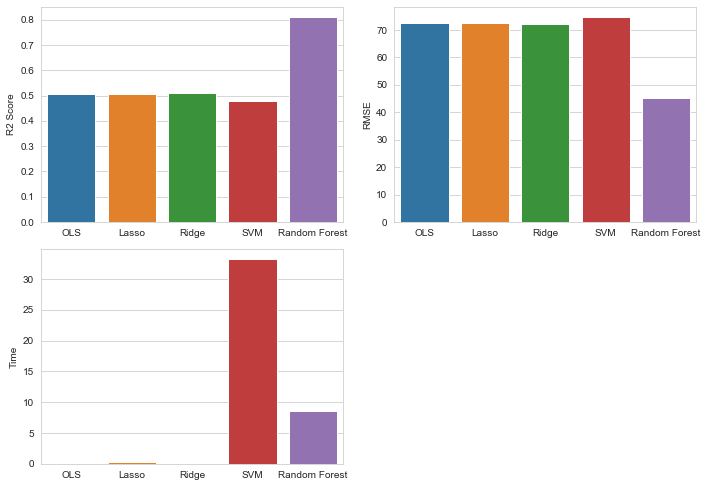

In [89]:
plt.subplots(figsize=(10, 10))

for index, column in enumerate(optimize_ghg_ess.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=optimize_ghg.index, y=column, data=optimize_ghg_ess)
plt.tight_layout()
plt.show()

In [69]:
final_ghg = pd.concat([scores_ghg, scores_ghg_ess], keys=["Sans EnergyStarScore", "Avec EnergyStarScore"])
final_ghg.round(2)

R2 Score    RMSE   Time
Sans EnergyStarScore Baseline OLS               -0.57  137.33   0.05
                              Lasso              0.55   73.80   0.04
                              Ridge              0.34   88.62   0.01
                              SVM                0.40   84.48   1.98
                              Random Forest      0.76   53.84   0.25
                     Optimize OLS               -0.57  137.33   0.01
                              Lasso              0.47   79.45   0.18
                              Ridge              0.35   88.11   0.00
                              SVM                0.41   84.30  15.91
                              Random Forest      0.79   50.32   5.76
Avec EnergyStarScore Baseline OLS                0.56   72.55   0.01
                              Lasso              0.56   72.65   0.04
                              Ridge              0.49   77.85   0.00
                              SVM                0.44   82.13   2.01
                              Random Forest      0.76   54.08   0.28
                     Optimize OLS                0.56   72.55   0.01
                              Lasso              0.56   72.96   0.18
                              Ridge              0.48   78.68   0.00
                              SVM                0.44   81.90  17.50
                              Random Forest      0.79   50.24   5.65

On peut noter que EnergyStarScore a un intérêt ici, on ce retrouve avec des models plus performant en prenant en compte EnergyStarScore.

On peut également noté que le model RandomForestRegressor est bien plus performant que les autres models, notre choix s'arrêtera donc dessus.